In [67]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from frequency_kstest_one_sided import FrequencyKSTestOneSided

import scienceplots    

np.random.seed(42)
plt.style.use(['no-latex', 'ieee'])

In [68]:
def select_alpha_gst_obrien_fleming(n, N, alpha, rho=0.5):
    t = n / N
    return 4 - 4 * sp.stats.norm.cdf(
            sp.stats.norm.ppf(1 - alpha / 4) / t ** (rho / 2)
        )

In [69]:
def bonferroni_correction(N_peek, alpha):
    return alpha / N_peek

In [70]:
def test_stop_ugst(treated_data, control_data, max_peek, alpha, factor_overestimation, bucket_values):
    total_data_size = len(treated_data)
    for i in range(1, max_peek + 1):
        data_received = int(np.ceil(sum(bucket_values[:i]) * total_data_size))
        p_value = FrequencyKSTestOneSided.p_value(treated_data[:data_received], control_data[:data_received])
        if p_value < select_alpha_gst_obrien_fleming(data_received, total_data_size * factor_overestimation, alpha): # it depends on the estimated size of the data
            return data_received
    return total_data_size

In [71]:
def test_stop_egst(treated_data, control_data, max_peek, alpha, bucket_values):
    total_data_size = len(treated_data)
    for i in range(1, max_peek + 1):
        data_received = int(np.ceil(sum(bucket_values[:i]) * total_data_size))
        p_value = FrequencyKSTestOneSided.p_value(treated_data[:data_received], control_data[:data_received])
        if p_value < select_alpha_gst_obrien_fleming(i, max_peek, alpha): # it depens on the number of peeks
            return data_received
    return total_data_size
            

In [72]:
def test_stop_sequential_bounds(treated_data, control_data, max_peek, alpha, bucket_values):
    total_data_size = len(treated_data)
    for i in range(1, max_peek + 1):
        data_received = int(np.ceil(sum(bucket_values[:i]) * total_data_size))
        p_value = FrequencyKSTestOneSided.p_value(treated_data[:data_received], control_data[:data_received], avi=True)
        if p_value < alpha:
            return data_received
    return total_data_size

In [73]:
def test_stop_bonferroni(treated_data, control_data, max_peek, alpha, bucket_values):
    total_data_size = len(treated_data)
    for i in range(1, max_peek + 1):
        data_received = int(np.ceil(sum(bucket_values[:i]) * total_data_size))
        p_value = FrequencyKSTestOneSided.p_value(treated_data[:data_received], control_data[:data_received])
        if p_value < bonferroni_correction(max_peek, alpha):
            return data_received
    return total_data_size


In [74]:
def get_buckets(n, power, bins):
    data = np.random.exponential(scale=1, size=n)

    # Transform the data to make it left-skewed
    left_skewed_data = np.power(data, power)

    normalized_data = left_skewed_data / left_skewed_data.sum()
    buckets = np.histogram(normalized_data, bins=bins, density=True)[0]
    bucket_values = buckets / buckets.sum()

    return bucket_values

Power: 0.2
Power: 0.4
Power: 0.6
Power: 0.8
Power: 1
Power: 1.2
Power: 1.4
Power: 1.6
Power: 1.8
Power: 2


Text(0, 0.5, 'Number of samples needed')

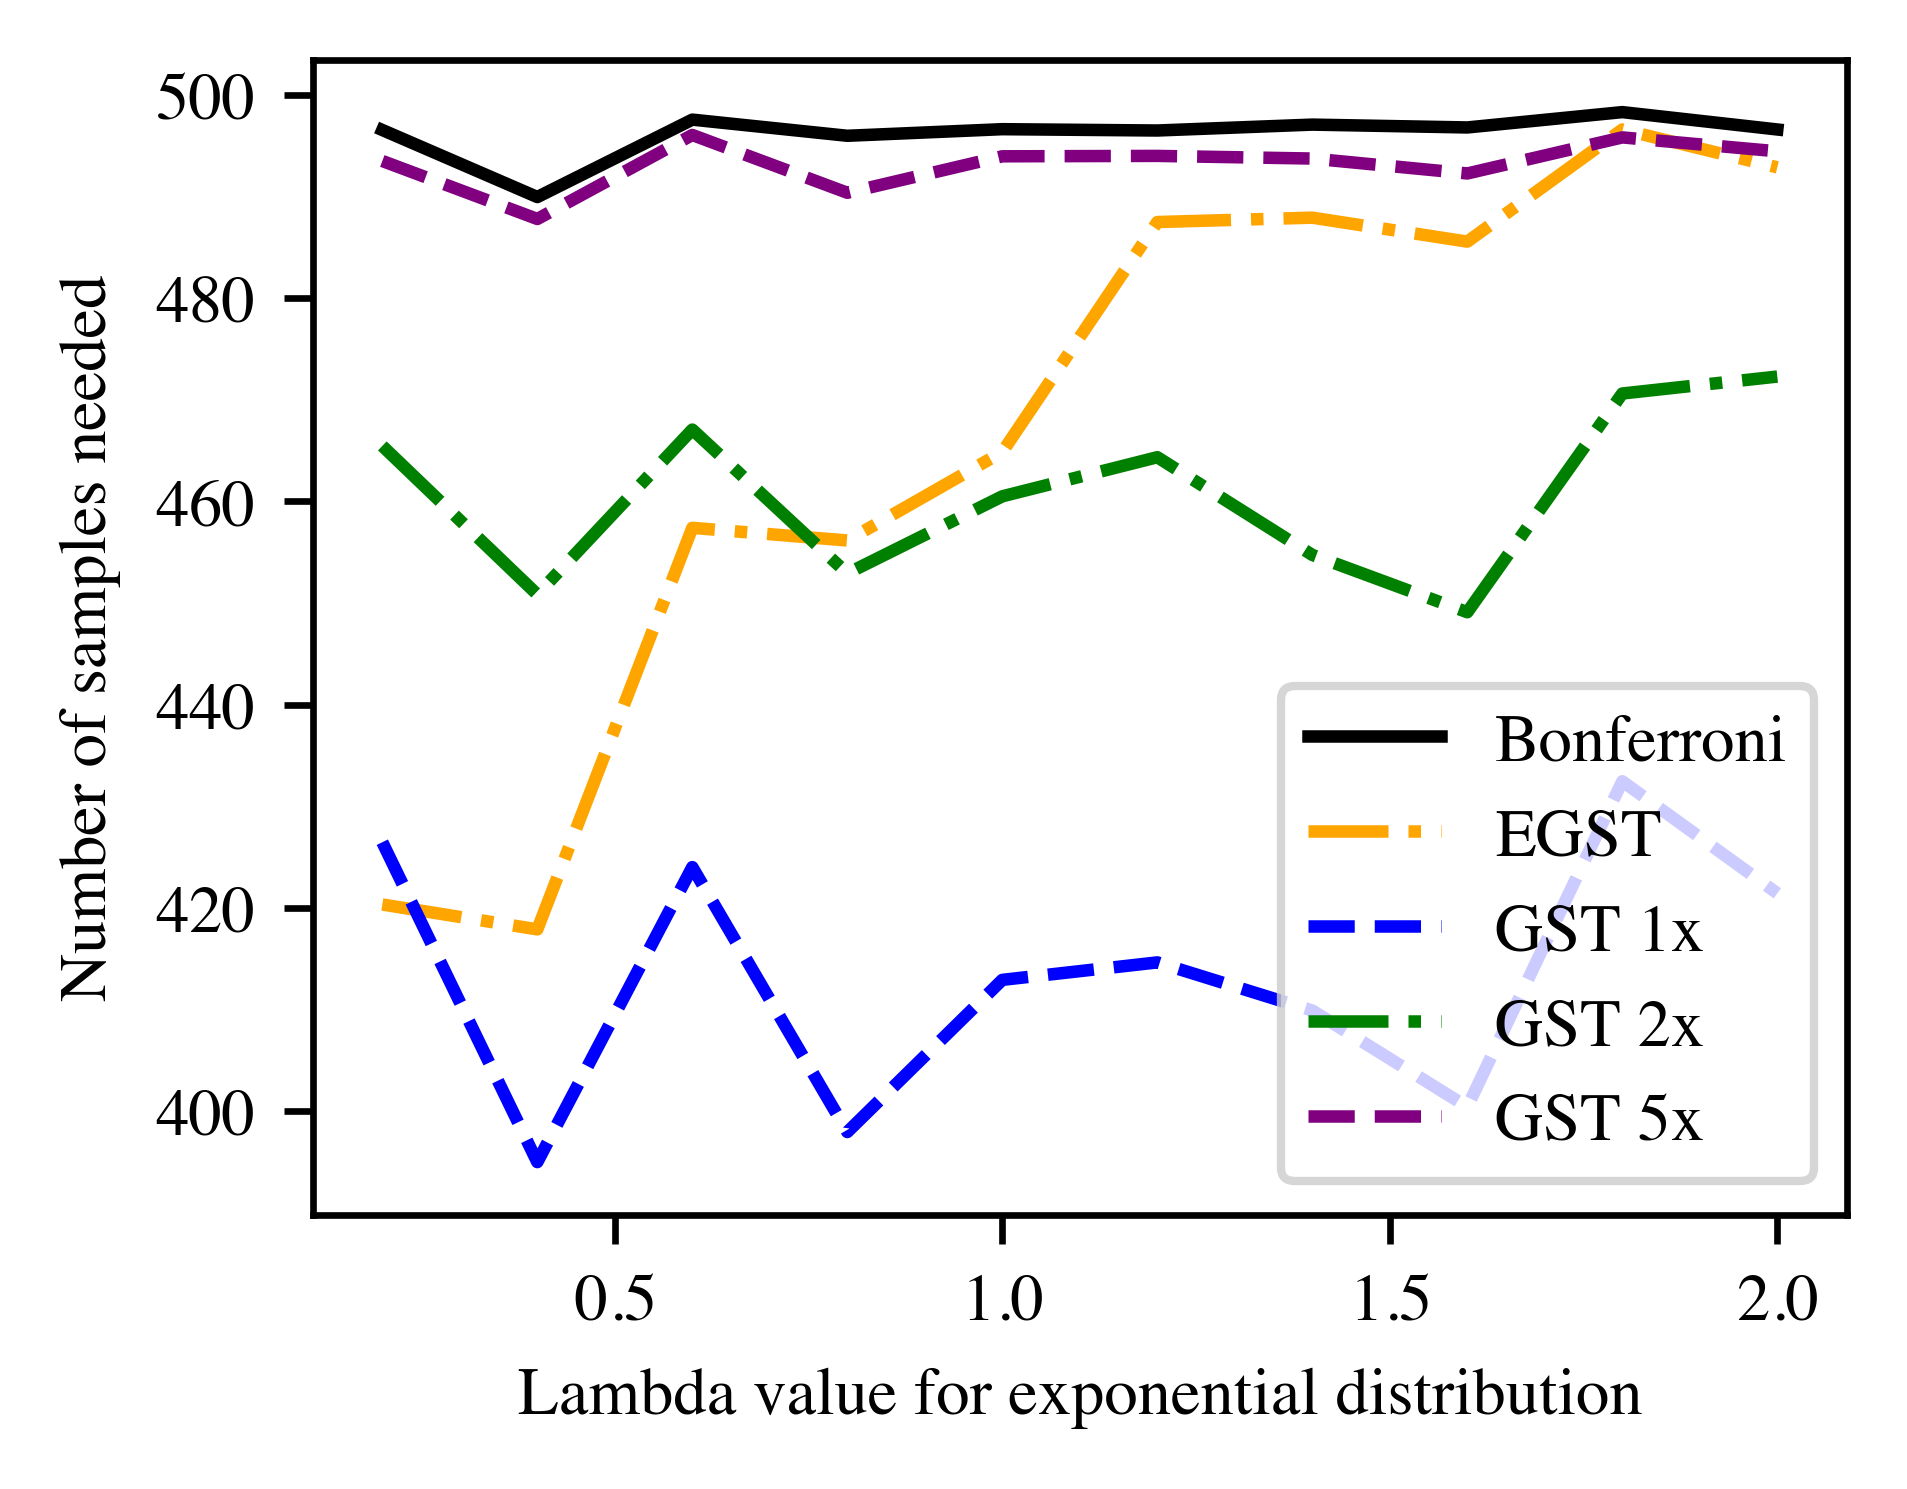

In [75]:
n = 500
effect_size = 0.3
alpha = 0.05
power_values = [0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2]
nof_buckets = 100

results_bonferroni = []
results_avi = []
results_egst = []
results_gst = []
result_gst_2 = []
results_gst_5 = []

for power in power_values:
    bucket_values = get_buckets(n, power, nof_buckets)

    local_results_bonferroni = []
    local_results_avi = []
    local_results_egst = []
    local_results_gst = []
    local_result_gst_2 = []
    local_results_gst_5 = []

    print(f"Power: {power}")
    for i in range(100):
        treated_data = np.random.normal(effect_size, 1, n)
        control_data = np.random.normal(0, 1, n)
        local_results_bonferroni.append(test_stop_bonferroni(treated_data, control_data, nof_buckets, alpha, bucket_values))
        # local_results_avi.append(test_stop_sequential_bounds(treated_data, control_data, nof_buckets, alpha, bucket_values))
        local_results_egst.append(test_stop_egst(treated_data, control_data, nof_buckets, alpha, bucket_values))
        local_results_gst.append(test_stop_ugst(treated_data, control_data, nof_buckets, alpha, factor_overestimation=1, bucket_values=bucket_values))
        local_result_gst_2.append(test_stop_ugst(treated_data, control_data, nof_buckets, alpha, factor_overestimation=2, bucket_values=bucket_values))
        local_results_gst_5.append(test_stop_ugst(treated_data, control_data, nof_buckets, alpha, factor_overestimation=5, bucket_values=bucket_values))

    results_bonferroni.append(np.mean(local_results_bonferroni))
    # results_avi.append(np.mean(local_results_avi))
    results_egst.append(np.mean(local_results_egst))
    results_gst.append(np.mean(local_results_gst))
    result_gst_2.append(np.mean(local_result_gst_2))
    results_gst_5.append(np.mean(local_results_gst_5))


plt.plot(power_values, results_bonferroni, label="Bonferroni", linestyle='solid', color='black')
# plt.plot(power_values, results_avi, label="AVI", linestyle='dotted', color='red')
plt.plot(power_values, results_egst, label="EGST", linestyle='dashdot', color='orange')
plt.plot(power_values, results_gst, label="GST 1x", linestyle='dashed', color='blue')
plt.plot(power_values, result_gst_2, label="GST 2x", linestyle='dashdot', color='green')
plt.plot(power_values, results_gst_5, label="GST 5x", linestyle='--', color='purple')
plt.legend()

plt.xlabel("Lambda value for exponential distribution")
plt.ylabel("Number of samples needed")